# CS445 Final Project
This project mainly focus on the topic of style transfer. The starting point for the topic start from the paper listed below:
https://arxiv.org/pdf/1508.06576.pdf, A Neural Algorithm of Artistic Style
https://arxiv.org/abs/1705.06830, Exploring the structure of a real-time, arbitrary neural artistic stylization network
## Part 1
resource: https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization
##### SetUp


In [25]:
import functools
import os
import copy
from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import IPython.display as display

In [3]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
    """Returns a cropped square image."""
    shape = image.shape
    new_shape = min(shape[1], shape[2])
    offset_y = max(shape[1] - shape[2], 0) // 2
    offset_x = max(shape[2] - shape[1], 0) // 2
    image = tf.image.crop_to_bounding_box(image, offset_y, offset_x, new_shape, new_shape)
    return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
    """Loads and preprocesses images."""
    # Cache image file locally.
    image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
    # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
    img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
    if img.max() > 1.0:
        img = img / 255.
    if len(img.shape) == 3:
        img = tf.stack([img, img, img], axis=-1)
    img = crop_center(img)
    img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
    return img

def show_n(images, titles=('',)):
    n = len(images)
#     print("n is: ", n)
    image_sizes = [image.shape[1] for image in images]
#     print("image_sizes: ", image_sizes)
    w = (image_sizes[0] * 6) // 320
#     print("w is: ", w)
    plt.figure(figsize=(w  * n, w))#decide the figure size
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
    for i in range(n):
#         print("i is, ", i)
        plt.subplot(gs[i])
        plt.imshow(images[i][0], aspect='equal')
        plt.axis('off')
        plt.title(titles[i] if len(titles) > i else '')
    plt.show()


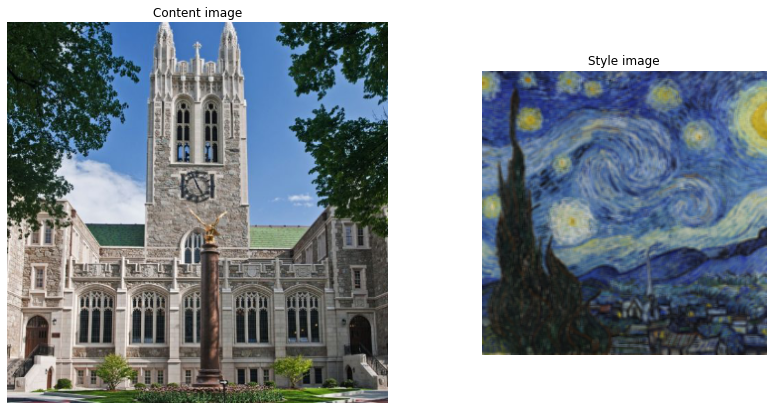

len(content_image):  384
len(style_image):  256


In [4]:
# @title Load example images  { display-mode: "form" }


content_image_url ='https://www.bc.edu/content/bc-web/offices/alumni/sites/landing-pages/bc-zoom-backgrounds/jcr:content/par/bc_padded_section/par/bc_padded_section/par/responsive_columns/col2/bc_image/image.transform/banner-medium/image.jpg'
# content_image_url = 'https://upload.wikimedia.org/wikipedia/en/7/7f/Pablo_Picasso%2C_1911%2C_Still_Life_with_a_Bottle_of_Rum%2C_oil_on_canvas%2C_61.3_x_50.5_cm%2C_Metropolitan_Museum_of_Art%2C_New_York.jpg'
# style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}

style_image_url = 'https://www.vangoghgallery.com/img/starry_night_full.jpg'
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)

style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')


# plt.imshow(content_image[0])
# plt.figure()
# plt.imshow(style_image[0])
# plt.figure()


show_n([content_image, style_image], ['Content image', 'Style image'])
print("len(content_image): ", len(content_image[0]))
print("len(style_image): ", len(style_image[0]))

In [5]:
#resource: https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [6]:
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

<Figure size 432x288 with 0 Axes>

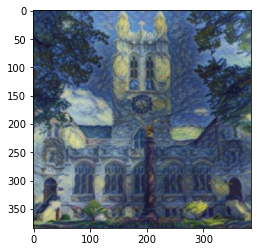

<Figure size 432x288 with 0 Axes>

In [7]:
plt.imshow(stylized_image[0])
plt.figure()

<Figure size 432x288 with 0 Axes>

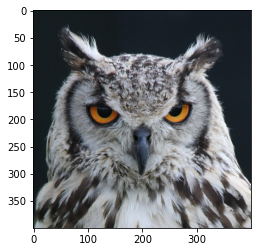

<Figure size 432x288 with 0 Axes>

In [8]:
# content_image_url ='https://www.bc.edu/content/bc-web/offices/alumni/sites/landing-pages/bc-zoom-backgrounds/jcr:content/par/bc_padded_section/par/bc_padded_section/par/responsive_columns/col2/bc_image/image.transform/banner-medium/image.jpg'

content_image_url = 'https://www.linvilla.com/wp-content/uploads/2016/12/2483210601_a25de5a5ca_m.jpg'

output_image_size = 400  # @param {type:"integer"}
content_img_size = (output_image_size, output_image_size)
content_image = load_image(content_image_url, content_img_size)
plt.imshow(content_image[0])
plt.figure()

In [9]:
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

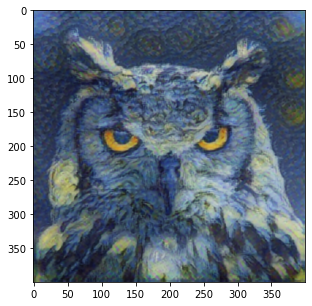

In [10]:
plt.figure(figsize=(10,5))
plt.imshow(stylized_image[0])
# plt.savefig("part1_test2.jpg")

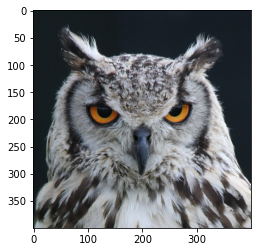

In [36]:
content_image_url = 'https://www.linvilla.com/wp-content/uploads/2016/12/2483210601_a25de5a5ca_m.jpg'
content_image = load_image(content_image_url, content_img_size)
plt.figure()
plt.imshow(content_image[0])

x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
# vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')


In [37]:
# vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# for layer in vgg.layers:
#     print(layer.name)

In [38]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
print("num_content_layers, ", num_content_layers)
print("num_style_layers, ", num_style_layers)

num_content_layers,  1
num_style_layers,  5


In [39]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    #get the model, the model is part of VGG
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
#     print(outputs)
    model = tf.keras.Model([vgg.input], outputs)
    
    return model

In [40]:
style_extractor = vgg_layers(style_layers) #style_layers: name of wanted layers in VGG
style_outputs = style_extractor(style_image*255)
# print(style_outputs)

In [41]:
def gram_matrix(input_tensor):
    """
    It turns out, the style of an image can be described by the means and 
    correlations across the different feature maps. Calculate a Gram matrix 
    that includes this information by taking the outer product of the feature 
    vector with itself at each location, and averaging 
    that outer product over all locations.
    """
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [42]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]

        style_outputs = [gram_matrix(style_output)for style_output in style_outputs]

        content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [43]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

# print('Styles:')
# for name, output in sorted(results['style'].items()):
#     print("  ", name)
#     print("    shape: ", output.numpy().shape)
#     print("    min: ", output.numpy().min())
#     print("    max: ", output.numpy().max())
#     print("    mean: ", output.numpy().mean())
#     print()

# print("Contents:")
# for name, output in sorted(results['content'].items()):
#     print("  ", name)
#     print("    shape: ", output.numpy().shape)
#     print("    min: ", output.numpy().min())
#     print("    max: ", output.numpy().max())
#     print("    mean: ", output.numpy().mean())

In [44]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

In [45]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [46]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4


In [47]:
def style_content_loss(outputs):
    #loss function
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [48]:
@tf.function()
def train_step(image):
    #update step
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [49]:
train_img = copy.deepcopy(image)

In [52]:
# # train_step(image)
# # train_step(image)
# # train_step(image)
import time
start = time.time()

epochs = 5
steps_per_epoch = 50


step = 0
# @tf.autograph.experimental.do_not_convert
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(m , end='')
    display.clear_output(wait=True)
#     display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Train step: 250
Total time: 349.2


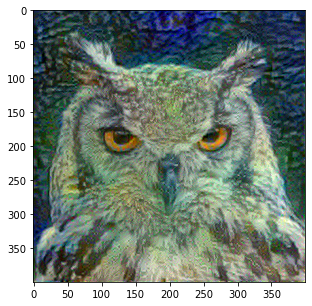

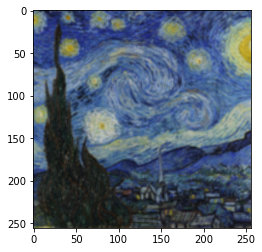

In [56]:
# tensor_to_image(image)
plt.figure(figsize=(10,5))
plt.imshow(image[0])
plt.figure()
plt.imshow(style_image[0])

In [55]:
# optimization


# Part 3 rewrite & optimization